# Ejercicio 3 - Resistencia al ruido.
## Enunciado.

Genere datasets con d = 5, n = 250 para el conjunto de entrenamiento y n = 10000 para el de test, variando el valor de C (overlapping de las clases) de 0.5 a 2.5 con incrementos de 0.5. Como en el punto anterior, para cada valor dado de C cree 20 conjuntos distintos de entrenamiento, pero uno solo de test. Genere una gráfica del test-error en función de C para el problema "paralelo" y el "diagonal" (sólo los promedios de los 20 conjuntos para cada valor de C).

También incluya en la gráfica los valores mínimos que se piden en el opcional 3.1 (el que no haga el opcional los puede pedir a la catedra). Todos los resultados de los dos problemas y el error mínimo en la misma gráfica. Discuta los resultados.

## Definición de funciones
Comencemos por definir las funciones que nos serviran para el caso de diagonales y el caso de paralelas.

In [106]:
from Generadores import diagonales, paralelas
from Comunes import standardTree
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss

In [107]:
# Definimos una funcion que dados los parametros y la lista de valores de C genere la lista de training sets
def generateTrainingSetsC(setCount, generator, d, n, cvals):

    # Inicializamos la lista de conjuntos de entrenamiento
    trainingSets = [[] for _ in range(len(cvals))]
    
    # Para cada valor de C
    for i, C in enumerate(cvals):

        # Generamos setCount conjuntos de entrenamiento de tamaño n
        for _ in range(setCount):
            trainingSets[i].append(generator(n, d, C))
            # time.sleep(1)    

    return trainingSets

In [108]:
# La funcion para generar clasificadores es identica a la del ejercicio anterior, donde setSizesCount es cValsCount
def generateClassifiers(cValsCount, setCount, trainingSets):
    # Creamos la lista de listas de clasificadores. La lista contiene setSizesCount listas con setCount clasificadores cada una.
    classifiers = [[] for _ in range(cValsCount)]
    
    # Creamos los clasificadores
    for classifierList in classifiers:
        for i in range(setCount):
            classifierList.append(standardTree())
    
    # Entrenamos los clasificadores con su set de entrenamiento correspondiente.
    for i,classifierList in enumerate(classifiers):
        for j,classifier in enumerate(classifierList):
            classifier.fit(list(trainingSets[i][j]["Input"]), list(trainingSets[i][j]["Output"]))

    return classifiers

In [109]:
# Devuelve testErrors como tupla.
def getPerformanceStats(cValsCount, setCount, testSets, classifiers):
    # Creamos una lista de listas de errores. La lista contiene cValsCount listas con setCount elementos cada una, de manera que 
    # testError[i][j] es el error de test para el classifier[i][j].
    
    # Esto sera la salida de nuestra funcion.
    testErrors     = [[] for _ in range(cValsCount)] 
    
    # Para cada lista de conjuntos de entrenamiento
    for i in range(cValsCount):
    
        # Y para cada conjunto de entrenamientos dentro de la lista
        for j in range(setCount):
    
            # Extraemos su clasificador asociado
            classifier = classifiers[i][j]
    
            # Predecimos los outputs sobre el conjunto de test y calculamos su loss
            testPredict = classifier.predict(list(testSets[i]["Input"]))
            testLoss = zero_one_loss(testSets[i]["Output"], testPredict)
            
            testErrors[i].append(testLoss)
    
    return testErrors

In [110]:
def plotErrors(testErrors, cVals):
    
    # Una vez calculados los errores y cantidad de nodos para cada par de clasificador y conjunto de entrenamiento, tomamos las medias
    meanTestErrors     = [np.mean(errorList) for errorList in testErrors]
    
    plt.figure(figsize = (10, 4))
    
    # Graficamos error de testeo
    plt.plot(cVals, meanTestErrors, color="orange", marker='s', linestyle='-', linewidth=2, markersize=8, label='Error de testeo diagonal')
    plt.xlabel("Varianza C", fontsize=12)
    plt.ylabel("Tasa de error", fontsize=12)
    plt.title("Error de testeo", fontsize=14)
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend(fontsize=10)
    
    # Marcamos los tamaños adecuados en el eje X
    axes = plt.gca()
    axes.set_xticks(cVals)  
    axes.get_xaxis().set_major_formatter(plt.ScalarFormatter()) # Esto cambia los numeros a notacion normal y no cientifica
    axes.tick_params(axis='x', which='minor', bottom=False)     # Esconde los ticks del eje que no son relevantes
    
    # Y setteamos los valores del eje Y para que matcheen con nuestros resultados
    axes.set_yticks(np.round(sorted(set(meanTestErrors)), decimals=2))
    
    plt.show()

## Definición de parámetros y clasificadores
Pasemos ahora a utilizar las funciones previamente definidas para generar los datos necesarios para entrenar a los distintos clasificadores.

In [111]:
# Definimos los parametros
d = 5
ntrain = 250
ntest = 10000
cvals = [0.5, 1, 1.5, 2, 2.5]

setCount = 20
cValsCount = 5

In [112]:
# Casos de test para diagonales.
testSetsDiagonales = []

for cval in cvals:
    testSetsDiagonales.append(diagonales(ntest,d,cval))
    # time.sleep(1)

trainingSetsDiagonales = generateTrainingSetsC(setCount, diagonales, d, ntrain, cvals)

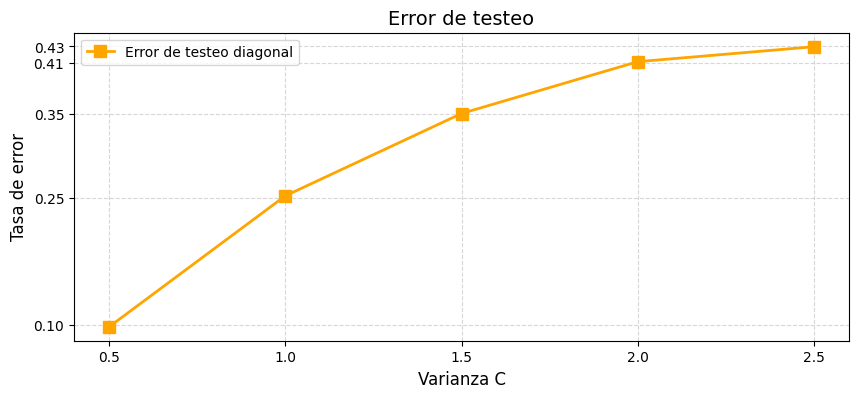

In [113]:
diagonalClassifiers = generateClassifiers(cValsCount, setCount, trainingSetsDiagonales)

testErrorsDiagonales = getPerformanceStats(cValsCount, setCount, testSetsDiagonales, diagonalClassifiers)

plotErrors(testErrorsDiagonales, cvals)

In [114]:
# Casos de test para paralelas.
testSetsParalelas = []

for cval in cvals:
    testSetsParalelas.append(paralelas(ntest,d,cval))
    # time.sleep(1)

trainingSetsParalelas = generateTrainingSetsC(setCount, paralelas, d, ntrain, cvals)

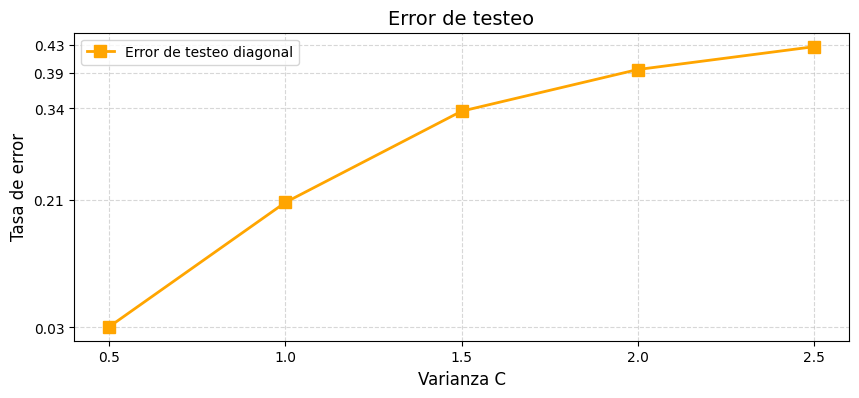

In [115]:
paralelasClassifiers = generateClassifiers(cValsCount, setCount, trainingSetsParalelas)

testErrorsParalelas = getPerformanceStats(cValsCount, setCount, testSetsParalelas, paralelasClassifiers)

plotErrors(testErrorsParalelas, cvals)

## Ejercicio 3.1 - Curva de error mínimo
Puede calcular para cada valor de C cuál es el mínimo error que se puede conseguir? Cómo se comparan dichos valores con los obtenidos con el árbol? Obtenga una curva de error mínimo y agréguela a la gráfica anterior. Explique brevemente cómo obtuvo los valores mínimos.
Hay varias maneras de hacerlo. Una simple es imaginando cuál es el clasificador ideal o de mínimo error para este problema (a ese clasificador se lo llama "clasificador de Bayes") y midiendo directamente sobre un conjunto de test grande (10000 puntos para d=5) cuántos puntos son mal clasificados por ese clasificador ideal. Para que verifiquen sus resultados, el error de Bayes para el diagonal con C=1.00 es 15.86%

## Resolución
Comencemos por construírnos los clasificadores de bayes para cada generador. La idea será, dado que conocemos los parámetros de las distribuciones normales que utilizan tanto paralelas como diagonales, crearnos dos clasificadores que dado un input calculan la probabilidad de que ese punto haya sido generado por cada una de las distribuciones y lo asignan a la clase que sea mas probable.

Definimos una función general *bayesClassifier* que construye el clasificador que describimos, asumiendo que se trata de un problema de clasificación binario donde las clases comparten el desvío estandar y tienen distintas medias.

In [116]:
# Clasificador de Bayes para un problema de clasificacion binario, en donde tenemos
# dos distribuciones definidas por sus medias y un desvío estandar común a las dos.

from scipy.stats import multivariate_normal

def bayesClassifier(data, meanClass0, meanClass1, standardDeviation):

    # Todos los puntos en data tienen la misma dimension
    d = len(data[0])

    covarianceMatrix = np.eye(d) * (standardDeviation ** 2)

    distributionClass0 = multivariate_normal(mean=meanClass0, cov=covarianceMatrix)
    distributionClass1 = multivariate_normal(mean=meanClass1, cov=covarianceMatrix)
    
    predictions = []
    
    for point in data:

        # Calculo la probabilidad respecto de ambas distribuciones
        probClass0 = distributionClass0.pdf(point)
        probClass1 = distributionClass1.pdf(point)

        if (probClass0 >= probClass1):
            predictions.append(0)
        else:
            predictions.append(1)

    return np.array(predictions)

Ahora, definimos el clasificador de bayes para cada uno de los generadores pasandole sus parámetros a *bayesClassifier*,

In [117]:
def bayesClassifierParallel(data, C):
    d = len(data[0])
    meanClass0 = np.full(d,0)
    meanClass0[0] = 1
    
    meanClass1 = np.full(d, 0)
    meanClass1[0] = -1
    
    return bayesClassifier(data, meanClass0, meanClass1, C * np.sqrt(d))
    
def bayesClassifierDiagonal(data, C):
    d = len(data[0])
    return bayesClassifier(data, np.full(d,-1), np.full(d,1), C * np.sqrt(d))
 

Calculamos el error de bayes para cada uno como el error del clasificador de bayes sobre un conjunto mas grande que el que usaremos para testear

In [118]:
bayesErrorsDiagonal = []
for cval in cvals:

    testSet     = diagonales(ntest * 10, d, cval)
    testPredict = bayesClassifierDiagonal(list(testSet["Input"]), cval)
    testLoss    = zero_one_loss(testSet["Output"], testPredict)

    bayesErrorsDiagonal.append(testLoss)
    
    print(f"C = {cval} -> error = {testLoss}")

bayesErrorsParallel = []
for cval in cvals:

    testSet     = paralelas(ntest * 10, d, cval)
    testPredict = bayesClassifierParallel(list(testSet["Input"]), cval)
    testLoss    = zero_one_loss(testSet["Output"], testPredict)

    bayesErrorsParallel.append(testLoss)
    
    print(f"C = {cval} -> error = {testLoss}")

# Observacion: dan igual. Sabiendo la distribución, el problema de clasificar los datos de paralelas() y de diagonales() son iguales pero rotados.

C = 0.5 -> error = 0.023170000000000024
C = 1 -> error = 0.15825999999999996
C = 1.5 -> error = 0.2538
C = 2 -> error = 0.31065
C = 2.5 -> error = 0.34287999999999996
C = 0.5 -> error = 0.023109999999999964
C = 1 -> error = 0.15958000000000006
C = 1.5 -> error = 0.25303
C = 2 -> error = 0.30969
C = 2.5 -> error = 0.34248999999999996


## Conclusiones
Veamos ahora en una misma gráfica ambas curvas de error junto con sus errores de bayes asociados.

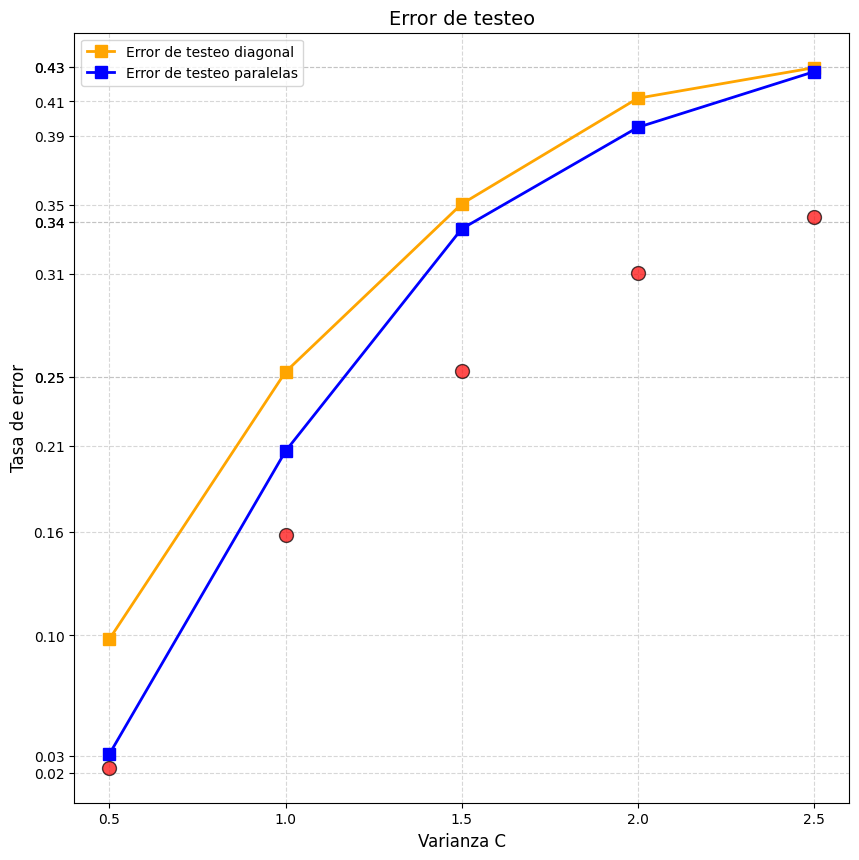

In [125]:
# Una vez calculados los errores y cantidad de nodos para cada par de clasificador y conjunto de entrenamiento, tomamos las medias
meanTestErrorsDiagonales     = [np.mean(errorList) for errorList in testErrorsDiagonales]
meanTestErrorsParalelas      = [np.mean(errorList) for errorList in testErrorsParalelas]

plt.figure(figsize = (10, 10))

# Graficamos error de testeo para cada generador
plt.plot(cvals, meanTestErrorsDiagonales, color="orange", marker='s', linestyle='-', linewidth=2, markersize=8, label='Error de testeo diagonal')
plt.plot(cvals, meanTestErrorsParalelas, color="blue", marker='s', linestyle='-', linewidth=2, markersize=8, label='Error de testeo paralelas')

# Y los errores de bayes para cada cval
plt.scatter(cvals, bayesErrorsDiagonal, color="red", marker='o', s=100, 
            edgecolor='black', alpha=0.7, zorder=3)
# plt.scatter(cvals, bayesErrorsParallel, color = "blue")  No lo ploteamos porque es igual. 


plt.xlabel("Varianza C", fontsize=12)
plt.ylabel("Tasa de error", fontsize=12)
plt.title("Error de testeo", fontsize=14)
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# Marcamos los tamaños adecuados en el eje X
axes = plt.gca()
axes.set_xticks(cvals)  
axes.get_xaxis().set_major_formatter(plt.ScalarFormatter()) # Esto cambia los numeros a notacion normal y no cientifica
axes.tick_params(axis='x', which='minor', bottom=False)     # Esconde los ticks del eje que no son relevantes

# Y setteamos los valores del eje Y para que matcheen con nuestros resultados
axes.set_yticks(np.round(sorted(set(meanTestErrorsDiagonales + meanTestErrorsParalelas + bayesErrorsDiagonal)), decimals=2))

plt.show()

Notemos que el comportamiento para ambos problemas es el mismo. Conforme aumenta la varianza, el desempeño de los clasificadores empeora. Esto se sustenta también por el aumento del error de bayes, podemos ver que incluso el clasificador ideal toma valores de error cada vez mas altos cuando la varianza aumenta.

Intuitivamente, un aumento en la varianza produce mayor superposición en los puntos de cada clase, por lo que los límites se vuelven mas difusos. Al aumentar la superposición, el error que se produce por tomar decisiones estadísticas inevitablemente aumenta, pues la cantidad (y por ende la proporción) de datos afectados por estas decisiones es mayor. Es decir, como la intersección de ambos conjuntos contiene mas datos, incluso el clasificador ideal etiquetará incorrectamente al menos a la mitad de los puntos que están en la "intersección" (si es que las clases están balanceadas, como es este caso).